# AR-based Anomaly detection with Smoothing

In [193]:
%reload_ext autoreload
%autoreload 2
from IPython.display import display

In [1]:
import sys

import matplotlib.pylab as plt
import numpy as np

sys.path.append('../')
from tsdr.outlierdetection.ar import AROutlierDetector

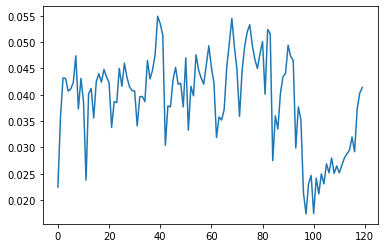

In [2]:
series = {'c-user_cpu_usage_seconds_total': [0.0225, 0.0357, 0.0432, 0.0431, 0.0407,
                                    0.0411, 0.0423, 0.0474, 0.0373, 0.0431,
                                    0.0388, 0.0238, 0.0402, 0.0412, 0.0356,
                                    0.0425, 0.044, 0.0424, 0.0448, 0.0434,
                                    0.0423, 0.0338, 0.0387, 0.0385, 0.045,
                                    0.0416, 0.046, 0.0433, 0.0415, 0.0408,
                                    0.0407, 0.0341, 0.0396, 0.0397, 0.0387,
                                    0.0465, 0.043, 0.0447, 0.0476, 0.0549,
                                    0.0535, 0.0513, 0.0304, 0.0379, 0.0377,
                                    0.0428, 0.0452, 0.042, 0.0422, 0.0377,
                                    0.047, 0.0333, 0.0416, 0.0398, 0.0476,
                                    0.0447, 0.0432, 0.042, 0.0456, 0.0493,
                                    0.0452, 0.0423, 0.0319, 0.0358, 0.0352,
                                    0.0372, 0.0452, 0.0497, 0.0545, 0.0491,
                                    0.0448, 0.0359, 0.0445, 0.0491, 0.0519,
                                    0.0533, 0.0494, 0.0467, 0.045, 0.0478,
                                    0.0501, 0.0401, 0.0524, 0.0516, 0.0275,
                                    0.036, 0.0335, 0.0403, 0.0434, 0.0441,
                                    0.0494, 0.0473, 0.0465, 0.0299, 0.0377,
                                    0.0353, 0.0214, 0.0174, 0.0231, 0.0247,
                                    0.0175, 0.0242, 0.0212, 0.025, 0.0231,
                                    0.0269, 0.0252, 0.028, 0.0251, 0.0265,
                                    0.0252, 0.0266, 0.028, 0.0288, 0.0295,
                                    0.032, 0.0292, 0.0373, 0.0403, 0.0414]}
plt.plot(series['c-user_cpu_usage_seconds_total'])

In [198]:
def ar_scores(x, ar_lag, ar_threshold):
    ar = AROutlierDetector(maxlag=ar_lag)
    scores, preds, model = ar.score(
        x=x,
        regression='n',
        lag=ar_lag,
        autolag=True if ar_lag == 0 else False,
        ic='bic',
    )
    print(f'lag: {model.ar_lags}')
    plt.plot(scores)
    if not np.all(np.isfinite(scores)):
        raise ValueError(f"scores must contain only finite values. {scores}")
    outliers, abn_th = ar.detect_by_fitting_dist(scores, threshold=ar_threshold)
    return outliers

lag: [1, 2]


[(42, 12.359436), (84, 15.895495)]

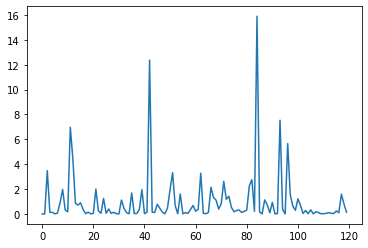

In [210]:
ar_threshold: float = 0.01
ar_lag: int = 0
ar_scores(np.array(series['c-user_cpu_usage_seconds_total']), ar_lag, ar_threshold)

In [7]:
def moving_average(x, w, mode='valid'):
    ret = np.convolve(x, np.ones(w), mode) / w
    plt.plot(ret)
    return ret

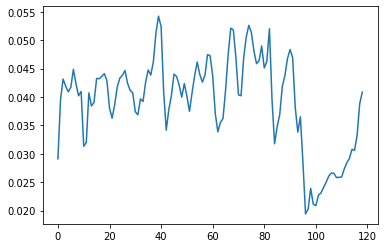

In [8]:
ma_x = moving_average(np.array(series['c-user_cpu_usage_seconds_total']), w=2, mode='valid')

lag: [1, 2, 3]


[(10, 9.977519), (41, 8.447899), (83, 17.630178), (95, 9.997074)]

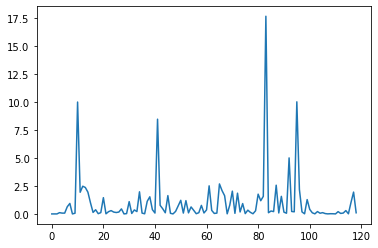

In [200]:
ar_scores(ma_x, 0, 0.01)

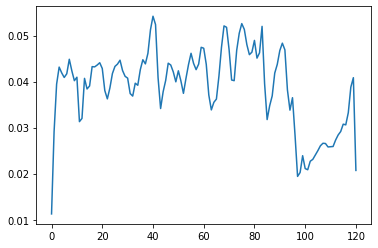

In [201]:
ma_x = moving_average(np.array(series['c-user_cpu_usage_seconds_total']), w=2, mode='full')

lag: [1, 2, 3]


[(84, 13.644405), (120, 24.766035)]

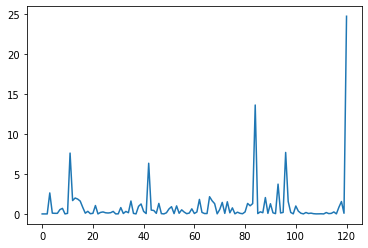

In [202]:
ar_scores(ma_x, 0, 0.01)

In [12]:
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def moving_average_cumsum(x, w):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    ret = (cumsum[w:] - cumsum[:-w]) / w
    plt.plot(ret)
    return ret

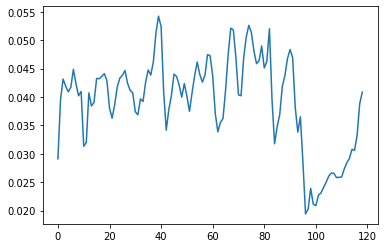

In [205]:
ma_x = moving_average_cumsum(np.array(series['c-user_cpu_usage_seconds_total']), w=2)

lag: [1, 2, 3]


[(10, 9.977519), (41, 8.447899), (83, 17.630178), (95, 9.997074)]

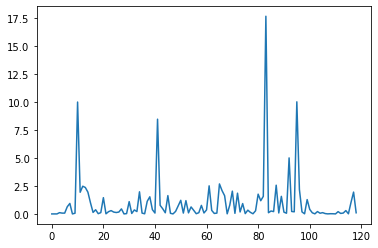

In [206]:
ar_scores(ma_x, 0, ar_threshold)

In [207]:
import scipy.ndimage as ndimg

def moving_average_uniform_filter1d(x, w, mode='constant'):
    ret = ndimg.uniform_filter1d(x, w, mode=mode, origin=-(w//2))[:-(w-1)]
    plt.plot(ret)
    return ret

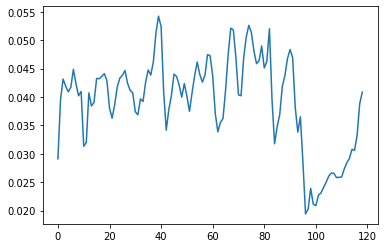

In [208]:
ma_x = moving_average_uniform_filter1d(np.array(series['c-user_cpu_usage_seconds_total']), w=2, mode='constant')

lag: [1, 2, 3]


[(10, 9.977519), (41, 8.447899), (83, 17.630178), (95, 9.997074)]

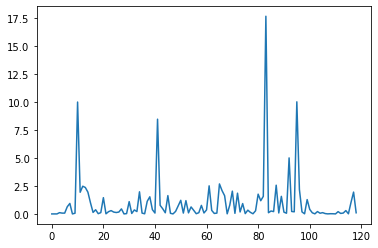

In [209]:
ar_scores(ma_x, 0, ar_threshold)

# tsmoothie

In [18]:
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

In [180]:
smoother = ExponentialSmoother(window_len=2, alpha=0)
smoother.smooth(np.array(series['c-user_cpu_usage_seconds_total']))

# generate intervals
low, up = smoother.get_intervals('sigma_interval')

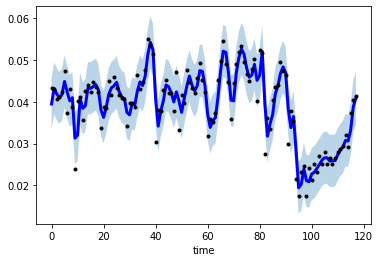

In [107]:
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

lag: [1, 2, 3, 4, 5]


[(9, 8.686181), (40, 9.063364), (82, 15.507991), (94, 9.803485)]

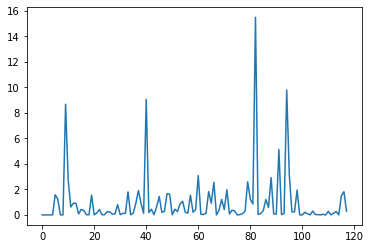

In [108]:
ar_scores(smoother.smooth_data[0], 0, ar_threshold)

In [186]:
# operate smoothing
smoother = ConvolutionSmoother(window_len=2, window_type='ones')
smoother.smooth(np.array(series['c-user_cpu_usage_seconds_total']))

# generate intervals
low, up = smoother.get_intervals('sigma_interval')

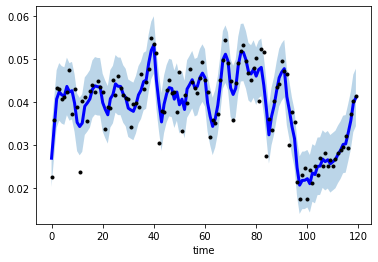

In [187]:
# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

lag: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


[(41, 10.039498), (83, 10.401404)]

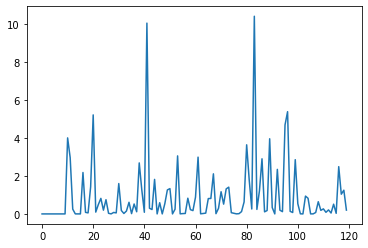

In [188]:
ar_scores(smoother.smooth_data[0], 0, ar_threshold)

In [215]:
# operate smoothing
smoother = BinnerSmoother(n_knots=int(120/7))
smoother.smooth(np.array(series['c-user_cpu_usage_seconds_total']))

# generate intervals
low, up = smoother.get_intervals('prediction_interval')
# np.set_printoptions(threshold=sys.maxsize)
# smoother.X

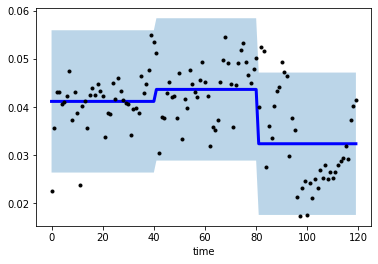

In [212]:
# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

lag: [1]


[(81, 112.330574)]

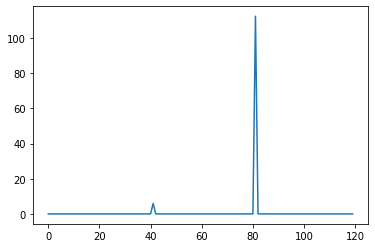

In [213]:
ar_scores(smoother.smooth_data[0], 0, ar_threshold)